# Opinion Dynamics control with OSAOC for larger networks

In [1]:
using PyPlot, LinearAlgebra, JuMP, Ipopt, Statistics, Permutations, SimpleValueGraphs, Graphs, Distributions, GraphPlot, LightGraphs
using Colors

In [2]:
include("karateclub_code.jl");
include("karateclub_plots.jl");

# Graph for Karate's Club

A real-world graph, [Zachary's Karate Club](https://www.jstor.org/stable/3629752), is used in this notebook as a larger example. It became a popular example of community structure in networks after its use by Michelle Girvan and Mark Newman in 2002 [(Here)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC122977/).

For opinion dynamics, this network is used as an example of real-world applications, for example: "[A social network group decision making framework with opinion dynamics considering opinion reliability](https://www.sciencedirect.com/science/article/pii/S0360835223005478)" and "[Dynamic behavior for social networks with state-dependent susceptibility and antagonistic interactions](https://www.sciencedirect.com/science/article/pii/S0005109821001722)". Both cases studies dynamics and consensus for this graph.

Our purpose is to control the agent's opinion using the methodology proposed in the work. The cell bellow loads the A matrix for the Karate Club's model. Note that we define two diferent dynamics: A_1 describes the case in which each agent ascribes equal weights to all neighbors and A_2 ascribes random weight to each neighbor.

In [3]:
#Zahary's Karate Club
G = Graphs.smallgraph(:karate)
G_2 = AdjacencyMatrix(G);
n = 34;
W = zeros(n,n)
for i in 1:n
    for j in 1:n
        if G_2[i,j] == true
            W[i,j] = 1
        else
            W[i,j] = 0
        end
    end
end
D = W*ones(n,1);
A_1 = zeros(n,n)
for i in 1:n
   A_1[i,:] = W[i,:]./D[i] 
end

#= For a directed graph, run this.
for i in 1:n
    for j in 1:n
        if G_2[i,j] == true
            W[i,j] = rand()
        else
            W[i,j] = 0
        end
    end
end
A_2 = rs_ize(W);
=#

# Graph plot

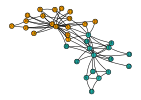

In [4]:
# nodes membership
nodelabel = collect(1:34)
membership = [1,1,1,1,1,1,1,1,2,2,1,1,1,1,2,2,1,1,2,1,2,1,2,2,2,2,2,2,2,2,2,2,2,2]
nodecolor = [colorant"lightseagreen", colorant"orange"]
# membership color
nodefillc = nodecolor[membership]
colors = [colorant"black"]
co = [colorant"black"]
gplot(G, nodefillc=nodefillc, nodelabel=nodelabel, edgestrokec=colors,linetype="curve", outangle=π/27, nodestrokec = co,
      nodestrokelw = true, NODELABELSIZE = 3.2)

# Control with (R)GS procedure

In cell bellow, we present the DeGroot model with RGS procedure. First we present Figure 9. Cell bellow set the initial conditions for the two groups.

In [5]:
#Agents initial conditions
N_a =  size(A_1,1) #number of agents
x_init = zeros(N_a,1)
#Instructor
x_init[1] = -1

#Agents with instructor:
i_upper_op = -0.8 #Min opinion for agents taking part with instructor
i_under_op = -1.2 #Max opinion for agents taking part with instructor
x_init[2:9] .= rand(Uniform(i_under_op,i_upper_op),8,1);
x_init[11:14] .= rand(Uniform(i_under_op,i_upper_op),4,1);
x_init[17:18] .= rand(Uniform(i_under_op,i_upper_op),2,1);
x_init[20] = rand(Uniform(i_under_op,i_upper_op));
x_init[22] = rand(Uniform(i_under_op,i_upper_op));

instructor_nodes = [1 2 3 4 5 6 7 8 9 11 12 13 14 17 18 20 22];

#President
x_init[34] = 1

#Agents with president
p_upper_op = 1.2 #Min opinion for agents taking part with president
p_under_op = 0.8 #Max opinion for agents taking part with president
x_init[10] = rand(Uniform(p_under_op,p_upper_op));
x_init[15:16] .= rand(Uniform(p_under_op,p_upper_op),2,1);
x_init[19] = rand(Uniform(p_under_op,p_upper_op));
x_init[21] = rand(Uniform(p_under_op,p_upper_op));
x_init[23:33] .= rand(Uniform(p_under_op,p_upper_op),11,1);

president_nodes = [10 15 16 19 21 23 24 25 26 27 28 29 30 31 32 33 34];

Setting player target, recalling that for Figure 9 both players has target equal 1, so we just present 1 objective (x_p_hat = 1). 

In [6]:
#Players targets
N_p = 2
x_p_hat = 1 #Player 1 is the president

targets = zeros(N_a,N_p)

for i in instructor_nodes[1:end] #Agents that the president is trying to convince to take his side
    targets[i,2] = x_p_hat
end

for i in president_nodes[1:end] #Agents that the instructor is trying to convince to take his side
    targets[i,1] = x_p_hat
end

#Control matrix
B = [targets[:,1]./x_p_hat targets[:,2]./x_p_hat];

# Fig 9
Run cell bellow to get the opinions and control over time. And the next one plots the Opinion of all agents over time for a consensus case.

In [8]:
γ = [0.001; 0.001]; #Control cost

#FJ model
Θ = 0 #Only to call the function

#HK model
F = 0; #Only to call the function
W = 0; #Only to call the function

T = 10; #horizon
proj_flag = 0; #Projection flag = 1, all opinios are projected in a [-1;1] opinions
perm_flag = 1;
model = 1 #Recalling that: 1 - DeGroot; 2 - FJ; 3 - HK

u_min = -0.5
u_max = 0.5

x_os, u_os = COD_OSA_GS(x_init,targets,γ,T,A_1,B,Θ,F,W,proj_flag,perm_flag, model);

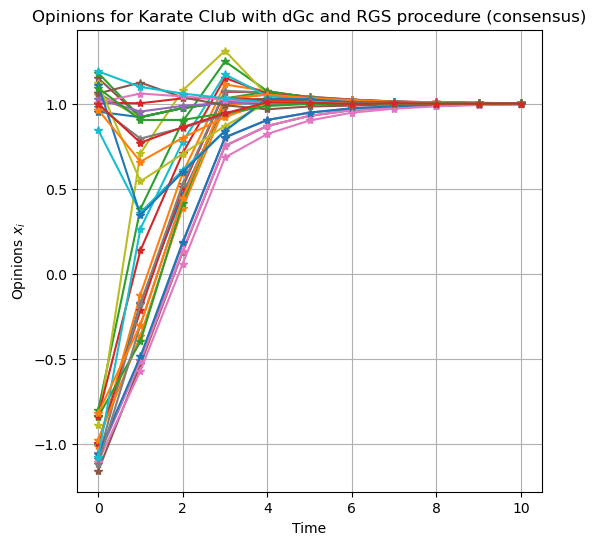

PyObject Text(28.0, 0.5, 'Opinions $x_i$')

In [9]:
figure(figsize=(6,6))
plot(x_os',"*-")
PyPlot.grid()
title("Opinions for Karate Club with dGc and RGS procedure (consensus)")
xlabel("Time")
ylabel(L"Opinions $x_i$")
#savefig("karate_fission_plus_consensus.eps")

# Plot for control

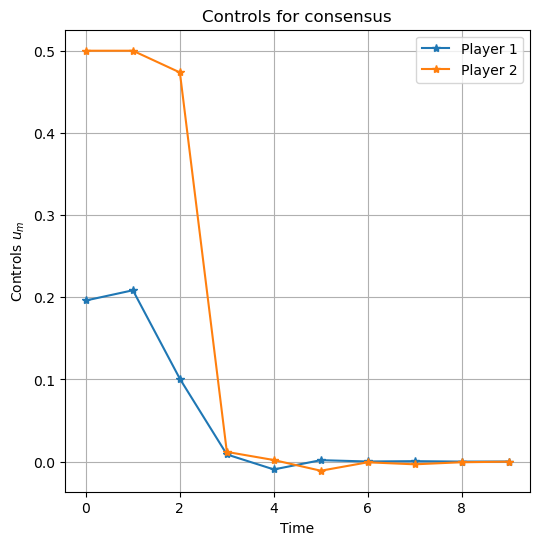

PyObject Text(0.5, 1.0, 'Controls for consensus')

In [10]:
figure(figsize=(6,6))
plot(u_os', "*-")
PyPlot.grid()
legend(["Player 1", "Player 2"])
xlabel("Time")
ylabel(L"Controls $u_m$")
title("Controls for consensus")
#savefig("karate_control_fission_plus_consensus.eps")

# Fig 10

The next cells are the codes for plotting Figure 10.

In [11]:
x_init = rand(Uniform(-2,2),34,1) #Initial conditions between -2 and 2

#Players targets
N_p = 2
x_p_hat = 1 #Player 1 is the president
x_i_hat = -1 #Player 2 is the instructor

targets = zeros(N_a,N_p)

#Players targets
for i in instructor_nodes[1:end] #Agents that the president is trying to convince to take his side
    targets[i,2] = x_i_hat
end

#Targets for the instructor
for i in president_nodes[1:end] #Agents that the instructor is trying to convince to take his side
    targets[i,1] = x_p_hat
end

B = [targets[:,1]./x_p_hat targets[:,2]./x_i_hat]; #B matrix

In [12]:
γ = [0.001; 0.001]; #Control cost

#FJ model
Θ = 0 #Only to call the function

#HK model
F = 0; #Only to call the function
W = 0; #Only to call the function

T = 60; #horizon
proj_flag = 0; #Projection flag = 1, all opinios are projected in a [-1;1] opinions
perm_flag = 1;
model = 1 #Recalling that: 1 - DeGroot; 2 - FJ; 3 - HK

u_min = -0.5
u_max = 0.5

x_os, u_os = COD_OSA_GS(x_init,targets,γ,T,A_1,B,Θ,F,W,proj_flag,perm_flag, model);

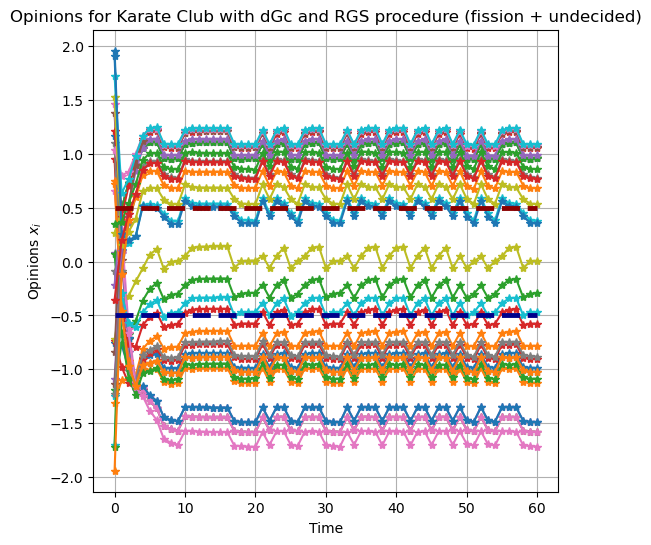

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000001BB4309ACB0>

In [13]:
figure(figsize=(6,6))
plot(x_os',"*-")
PyPlot.grid()
title("Opinions for Karate Club with dGc and RGS procedure (fission + undecided)")
xlabel("Time")
ylabel(L"Opinions $x_i$")
plot(0.5*ones(T+1,1), "--", color = :darkred, linewidth = 3.5)
plot(-0.5*ones(T+1,1), "--", color = :darkblue, linewidth = 3.5)
#savefig("karate_fission_plus_consensus.eps")

# EXTRA: Complete Fission

Quote from paper: "_Complete fission of the group is possible with just a small change in the matrix A: the graph should have smaller weights on the edges connecting the different groups compared to the edges within the group itself_". Thefore, cell bellow do that.

In [14]:
#Agents connected with agents from other group
A_1[1,32] = 0.001; A_1[32,1] = 0.001;

A_1[2,31] = 0.001; A_1[31,2] = 0.001;

A_1[3,10] = 0.001; A_1[3,28] = 0.001; A_1[3,29] = 0.001; A_1[3,33] = 0.001;
A_1[10,3] = 0.001; A_1[28,3] = 0.001; A_1[29,3] = 0.001; A_1[33,3] = 0.001;

A_1[9,31] = 0.001; A_1[9,33] = 0.001; A_1[9,34] = 0.001; 
A_1[31,9] = 0.001; A_1[33,9] = 0.001; A_1[34,9] = 0.001;

A_1[14,34] = 0.001; A_1[34,14] = 0.001;

A_1[20,34] = 0.001; A_1[34,20] = 0.001;

A_1 = rs_ize(A_1);

The next cells compute de opinion evolution over time and present the plots.

In [15]:
x_init = rand(Uniform(-2,2),34,1)

#Players targets
N_p = 2
x_p_hat = 1 #Player 1 is the president
x_i_hat = -1 #Player 2 is the instructor

targets = zeros(N_a,N_p)

#Targets for the president

for i in instructor_nodes[1:end] #Agents that the president is trying to convince to take his side
    targets[i,2] = x_i_hat
end

#Targets for the instructor
for i in president_nodes[1:end] #Agents that the instructor is trying to convince to take his side
    targets[i,1] = x_p_hat
end

#Control matrix
B = [targets[:,1]./x_p_hat targets[:,2]./x_i_hat];

In [16]:
γ = [0.001; 0.001]; #Control cost

#FJ model
Θ = 0 #Only to call the function

#HK model
F = 0; #Only to call the function
W = 0; #Only to call the function

T = 60; #horizon
proj_flag = 0; #Projection flag = 1, all opinios are projected in a [-1;1] opinions
perm_flag = 1;
model = 1 #Recalling that: 1 - DeGroot; 2 - FJ; 3 - HK

u_min = -0.5
u_max = 0.5

x_os, u_os = COD_OSA_GS(x_init,targets,γ,T,A_1,B,Θ,F,W,proj_flag,perm_flag, model);

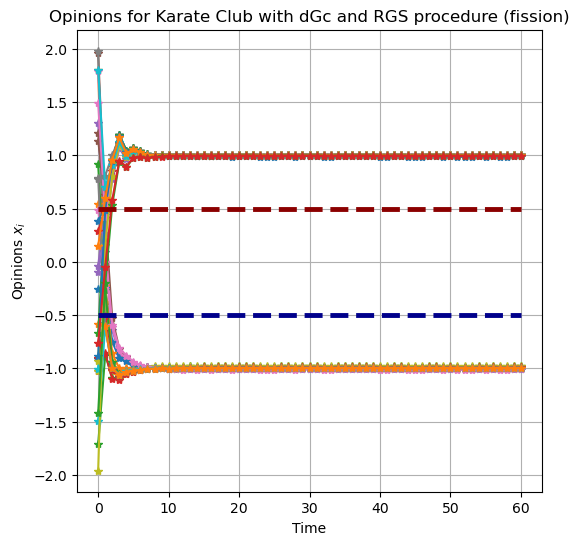

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000001BB9CAD0400>

In [17]:
figure(figsize=(6,6))
plot(x_os',"*-")
PyPlot.grid()
title("Opinions for Karate Club with dGc and RGS procedure (fission)")
xlabel("Time")
ylabel(L"Opinions $x_i$")
plot(0.5*ones(T+1,1), "--", color = :darkred, linewidth = 3.5)
plot(-0.5*ones(T+1,1), "--", color = :darkblue, linewidth = 3.5)
#savefig("karate_fission_plus_consensus.eps")